# Data pre-processing

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import LabelEncoder

#%% load UCI Adult dataset from downloaded zip folder
labels = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 
          'marital-status', 'occupation', 'relationship', 'race', 'sex', 
          'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 
          'income']

train_df = pd.read_csv('../input/uci-adult/adult.data', na_values='?', header=None, names=labels, skipinitialspace=True)
test_df = pd.read_csv('../input/uci-adult/adult.test', na_values='?', header=None, names=labels, skipinitialspace=True)
train_df.dropna(axis=0, how='any', inplace=True)
test_df.dropna(axis=0, how='any', inplace=True)

# keep a copy to compare with processed data
data = pd.concat([train_df, test_df], axis=0)

In [3]:
#%% analyse features
target = train_df.values[:,14] # change column index 0-14
counter = Counter(target)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Class=%s, Count=%d, Percentage=%.3f%%' % (k, v, per))

Class=<=50K, Count=22654, Percentage=75.108%
Class=>50K, Count=7508, Percentage=24.892%


In [4]:
#%% drop redundant column
train_df.drop(labels=['education'], axis=1, inplace=True)
test_df.drop(labels=['education'], axis=1, inplace=True)

In [5]:
#%% convert 'income' to integer
salary_map={'<=50K':0,'>50K':1}
salary_map2={'<=50K.':0,'>50K.':1}

train_df['income']=train_df['income'].map(salary_map).astype(int)
test_df['income']=test_df['income'].map(salary_map2).astype(int)

In [6]:
#%% process 'capital-gain' and 'capital-loss'
train_df.loc[(train_df['capital-gain'] > 0),'capital-gain'] = 1    #capital loss and gain has a lot of zero values 
train_df.loc[(train_df['capital-gain'] == 0 ,'capital-gain')]= 0

test_df.loc[(test_df['capital-gain'] > 0),'capital-gain'] = 1    #capital loss and gain has a lot of zero values 
test_df.loc[(test_df['capital-gain'] == 0 ,'capital-gain')]= 0

train_df.loc[(train_df['capital-loss'] > 0),'capital-loss'] = 1
train_df.loc[(train_df['capital-loss'] == 0 ,'capital-loss')]= 0

test_df.loc[(test_df['capital-loss'] > 0),'capital-loss'] = 1
test_df.loc[(test_df['capital-loss'] == 0 ,'capital-loss')]= 0

#%% convert object type data to integers
for col in train_df.columns:
    if train_df[col].dtype == 'object':
        encoder = LabelEncoder()
        encoder.fit(train_df[col])
        train_df[col] = encoder.transform(train_df[col])
        encoder.fit(test_df[col])
        test_df[col] = encoder.transform(test_df[col])

In [7]:
#%% separate X and y
X_train = train_df.drop(['income'], axis=1).to_numpy()
y_train = train_df['income'].to_numpy()
X_test = test_df.drop(['income'], axis=1).to_numpy()
y_test = test_df['income'].to_numpy()

print(X_train.shape)
print(y_train.shape)

(30162, 13)
(30162,)


# Model: Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(penalty='l2', C=1.0, solver='newton-cholesky', max_iter=1000)
model.fit(X_train, y_train)
print("Training accuracy: ", model.score(X_train, y_train))
print("Test accuracy: ", model.score(X_test, y_test))

Training accuracy:  0.8125787414627678
Test accuracy:  0.8135458167330677


In [20]:
from sklearn.preprocessing import StandardScaler

#%% standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression(penalty='l2', C=1.0, solver='newton-cholesky', max_iter=1000)
model.fit(X_train, y_train)
print("Training accuracy: ", model.score(X_train, y_train))
print("Test accuracy: ", model.score(X_test, y_test))

Training accuracy:  0.8125124328625423
Test accuracy:  0.8133466135458167


In [28]:
#%% tune various hyperparameters using GridSearchCV()
from sklearn.model_selection import GridSearchCV

# define the parameter grid
param_grid = {
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
    'max_iter': [100, 500, 1000]
}

# grid search for best hyperparameters with 5-fold cross-validation
model = LogisticRegression()
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'max_iter': [100, 500, 1000], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']})

In [29]:
# print the best hyperparameters
best_params = grid_search.best_params_

print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'C': 10, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}


In [ ]:
# compute the accuracy score for each hyperparameter combination
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print(f"Accuracy: {mean:.3f} (±{std*2:.3f}) for {params}")

In [31]:
results_df = pd.DataFrame(grid_search.cv_results_)
results_df_sorted = results_df.sort_values(by='mean_test_score', ascending=False)

# Extract relevant columns
param_cols = ['param_max_iter', 'param_C', 'param_penalty', 'param_solver']
mean_test_score_col = 'mean_test_score'

# Display average accuracy for each hyperparameter combination
print(results_df_sorted[param_cols + [mean_test_score_col]])

   param_max_iter  param_C param_penalty param_solver  mean_test_score
83           1000       10            l2         saga         0.812380
75            100       10            l2         saga         0.812380
82           1000       10            l2    liblinear         0.812380
81           1000       10            l1         saga         0.812380
72            100       10            l1    liblinear         0.812380
..            ...      ...           ...          ...              ...
13            100   0.0001            l1         saga         0.751078
21           1000   0.0001            l1         saga         0.751078
16            500   0.0001            l1    liblinear         0.751078
17            500   0.0001            l1         saga         0.751078
0             100  0.00001            l1    liblinear         0.751078

[84 rows x 5 columns]


In [32]:
#%% final evaluation with best hyperparameters
model = LogisticRegression(penalty=best_params['penalty'], C=best_params['C'], 
                           solver=best_params['solver'], max_iter=best_params['max_iter'])
model.fit(X_train, y_train)
print("Training accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

Training accuracy: 0.8125124328625423
Test accuracy: 0.8134130146082338


In [33]:
#%% 
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, confusion_matrix

# make predictions
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print or use the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8134130146082338
Precision: 0.6775738228252195
Recall: 0.4589189189189189
F1 Score: 0.5472123751208507


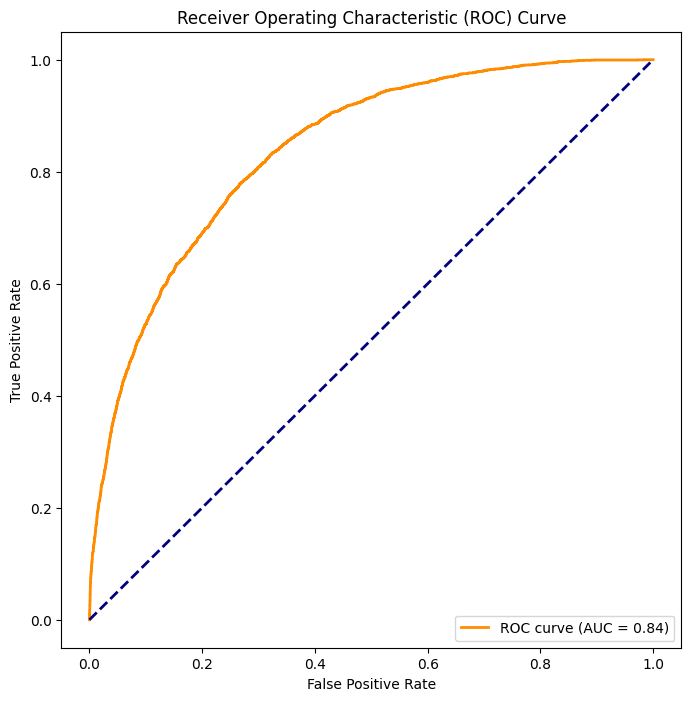

In [34]:
#%%
from sklearn.metrics import roc_curve, auc

# probability estimates for positive class
y_prob = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# plt.savefig('LogReg_Adult_ROC-AUC.pdf', bbox_inches='tight')

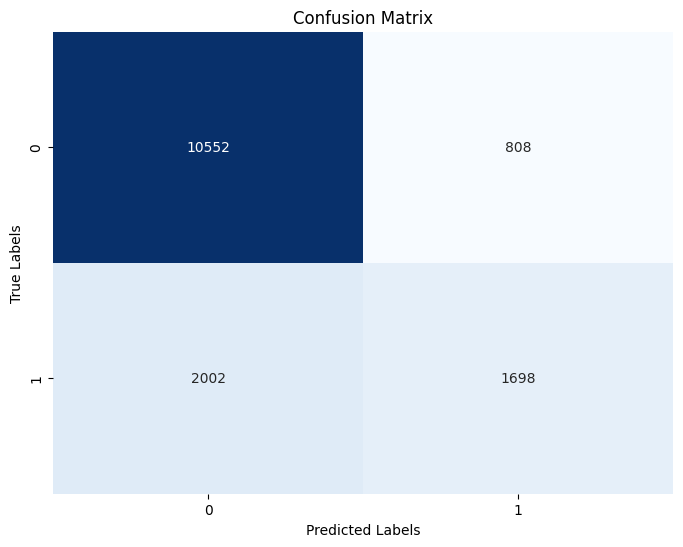

In [35]:
#%%
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# plt.savefig('LogReg_Adult_ConfMat.pdf', bbox_inches='tight')

# Bootstrap

In [36]:
from sklearn.model_selection import KFold

In [37]:
# Number of bootstrap datasets
B = 300
n = X_train.shape[0]

# Storing average validation accuracies for each bootsrap dataset
bootstrap_accuracies = []

# initializing KFold
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=28)

# Non-parametric bootstrap
for b in range(B):
    # Resampling with replacement
    indices = np.random.choice(n, n, replace=True)
    X_b = X_train[indices]
    y_b = y_train[indices]
    
    accuracies = []

    # Loop over folds
    for train_index, val_index in kf.split(X_b):
        X_train_fold, X_val_fold = X_b[train_index], X_b[val_index]
        y_train_fold, y_val_fold = y_b[train_index], y_b[val_index]

        # Training
        model = LogisticRegression(penalty=best_params['penalty'], C=best_params['C'], 
                                   solver=best_params['solver'], max_iter=best_params['max_iter'])
        model.fit(X_train_fold, y_train_fold)

        # Computing accuracy on the validation fold
        accuracy = model.score(X_val_fold, y_val_fold)
        accuracies.append(accuracy)

    # Storing average validation accuracy for this bootstrap dataset
    avg_accuracy = np.mean(accuracies)
    print(f"Average validation accuracy for bootstrap dataset {b} = {avg_accuracy:.3f}")
    bootstrap_accuracies.append(avg_accuracy)

Average validation accuracy for bootstrap dataset 0 = 0.811
Average validation accuracy for bootstrap dataset 1 = 0.812
Average validation accuracy for bootstrap dataset 2 = 0.812
Average validation accuracy for bootstrap dataset 3 = 0.811
Average validation accuracy for bootstrap dataset 4 = 0.816
Average validation accuracy for bootstrap dataset 5 = 0.809
Average validation accuracy for bootstrap dataset 6 = 0.812
Average validation accuracy for bootstrap dataset 7 = 0.818
Average validation accuracy for bootstrap dataset 8 = 0.810
Average validation accuracy for bootstrap dataset 9 = 0.809
Average validation accuracy for bootstrap dataset 10 = 0.815
Average validation accuracy for bootstrap dataset 11 = 0.811
Average validation accuracy for bootstrap dataset 12 = 0.812
Average validation accuracy for bootstrap dataset 13 = 0.810
Average validation accuracy for bootstrap dataset 14 = 0.811
Average validation accuracy for bootstrap dataset 15 = 0.813
Average validation accuracy for bo

In [38]:
# Computing percentiles
mean_acc = np.mean(bootstrap_accuracies)
percentile_5 = np.percentile(bootstrap_accuracies, 5, axis=0)
percentile_95 = np.percentile(bootstrap_accuracies, 95, axis=0)

print("Mean: ", mean_acc)
print("5th percentile: ", percentile_5)
print("95th percentile: ", percentile_95)

Mean:  0.8119691234937874
5th percentile:  0.8079019144154541
95th percentile:  0.8156305651036891
